# Предсказание увольнения сотрудников

<a id='task'></a>
## Постановка задачи

**Тема проекта:** использование моделей машинного обучения для улучшения быстроты и точности ответов на вопросы бизнеса.

### Назначение

**Цели проекта:** 
- Построить модель, предсказывающую уровень удовлетворённости сотрудника на основе данных заказчика.
- Построить модель, предсказывающую увольнение сотрудника из компании на основе данных заказчика.

### Структура проекта
1. [Постановка задачи][1]
    1. Назначение
    2. Структура проекта
    3. Описание данных
2. [Задача 1: предсказание уровня удовлетворённости сотрудника][2]
    1. [Загрузка данных][2.1]
    2. [Предобработка данных][2.2]
    3. [Исследовательский анализ данных][2.3]
    4. [Подготовка данных][2.4]
    5. [Обучение моделей][2.5]
    6. [Промежуточные выводы][2.6]
3. [Задача 2: предсказание увольнения сотрудника из компании][3]
    1. [Загрузка данных][3.1]
    2. [Предобработка данных][3.2]
    3. [Исследовательский анализ данных][3.3]
    4. [Добавление нового входного признака][3.4]
    5. [Подготовка данных][3.5]
    6. [Обучение моделей][3.6]
    7. [Промежуточные выводы][3.7]
4. [Общий вывод][4]
    
[1]:#task
[2]:#task1
[2.1]:#gen1
[2.2]:#prep1
[2.3]:#res1
[2.4]:#pipe1
[2.5]:#mod1
[2.6]:#conc1
[3]:#task2
[3.1]:#gen2
[3.2]:#prep2
[3.3]:#res2
[3.4]:#add
[3.5]:#pipe2
[3.6]:#mod2
[3.7]:#conc2
[4]:#conc

### Описание данных

**Задача 1: предсказание уровня удовлетворённости сотрудника.**

Для этой задачи заказчик предоставил данные с признаками:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Таблицы:
- Тренировочная выборка: `train_job_satisfaction_rate.csv`
- Входные признаки тестовой выборки: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`

**Задача 2: предсказание увольнения сотрудника из компании.**

Для этой задачи используются те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это `quit` — увольнение сотрудника из компании.

Таблицы:
- Тренировочная выборка: `train_quit.csv`
- Входные признаки тестовой выборки те же, что и в прошлой задаче: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_quit.csv`

<a id='task1'></a>
## Задача 1: предсказание уровня удовлетворённости сотрудника

Подготовка к работе с данными: загружаем библиотеки.

In [1]:
!pip install phik  -q

In [2]:
# импорт библиотек
import numpy as np
import pandas as pd
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings("ignore")
import os

# библиотеки для графиков
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import (
    roc_auc_score, 
    make_scorer
)

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


RANDOM_STATE = 34

In [4]:
# подготовка графиков
palette = ["#F72585", "#4361EE", 
           "#b5179e", "#4CC9F0", 
           "#7209B7", "#3A0CA3"]
sns.set(rc={'figure.figsize':(7, 6)}, 
        palette=palette, 
        font_scale=0.95)
sns.set_style(rc = {'axes.facecolor': '#e9e9f0'})

<a id='gen1'></a>
### Загрузка данных

Считываем датафреймы.

In [5]:
# функция считывания датафрейма
def read_dfs(path, name, sep):
    for i in path:
        if os.path.exists(i+name):
            return pd.read_csv(i+name, sep=sep[0], decimal=sep[1])
    return print('File not found')

In [6]:
# считываем датафреймы
# записываем возможные пути
paths = ['/datasets/', 
         'C:\\Users\\Admin\\YandexDisk\\']
# разделение данных
sep=[',', '.']

df_name = 'train_job_satisfaction_rate.csv'
train_rate = read_dfs(paths, df_name, sep)

df_name = 'test_features.csv'
test_features= read_dfs(paths, df_name, sep)

df_name = 'test_target_job_satisfaction_rate.csv'
test_rate = read_dfs(paths, df_name, sep)

Проверяем данные в датафреймах.

In [7]:
print(train_rate.info())
train_rate.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


**Вывод:** есть пропуски, типы данных правильные.

In [8]:
print(test_features.info())
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


**Вывод:** есть пропуски, типы данных правильные.

In [9]:
print(test_rate.info())
test_rate.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**Вывод:** пропусков нет, типы данных правильные.

<a id='prep1'></a>
### Предобработка данных

Проверим данные на наличие явных дубликатов.

In [10]:
print('Кол-во дубликатов в train_rate:', 
      train_rate.duplicated().sum())
print('Кол-во дубликатов в test_features:', 
      test_features.duplicated().sum())
print('Кол-во дубликатов в test_rate:', 
      test_rate.duplicated().sum())

Кол-во дубликатов в train_rate: 0
Кол-во дубликатов в test_features: 0
Кол-во дубликатов в test_rate: 0


Явных дубликатов нет.

Проверим данные на наличие неявных дубликатов.

In [11]:
# выбираем только категориальные признаки
cat_col = train_rate\
.select_dtypes(exclude=['number']).columns

for col in cat_col:
    print('Столбец', col, train_rate[col].unique())

Столбец dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Столбец level ['junior' 'middle' 'sinior' nan]
Столбец workload ['medium' 'high' 'low']
Столбец last_year_promo ['no' 'yes']
Столбец last_year_violations ['no' 'yes']


В датафрейме `train_rate` нет неявных дубликатов, но есть пропуски.

In [12]:
for col in cat_col:
    print('Столбец', col, test_features[col].unique())

Столбец dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Столбец level ['junior' 'middle' 'sinior' nan]
Столбец workload ['medium' 'low' 'high' ' ']
Столбец last_year_promo ['no' 'yes']
Столбец last_year_violations ['no' 'yes']


В датафрейме `test_features` есть пропуски и неявные дубликаты: `' '` - значит отсутствующее значение, то есть `nan`. Приведем все пропуски к одному виду.

Избавимся от пропусков с помощью пайплайна.

In [13]:
# выбираем только категориальные признаки
cat_col = train_rate\
.select_dtypes(exclude=['number']).columns

imput_cat = Pipeline(
    [('nan_imputer', 
      SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('space_imputer', 
     SimpleImputer( missing_values=' ', strategy='most_frequent'))
    ]
)

prep_imput =  ColumnTransformer(
    transformers=[
        ('imput_cat',
         imput_cat,
         cat_col)],
    remainder='passthrough'
)

In [14]:
train = train_rate[cat_col]
test = test_features[cat_col]

train = prep_imput.fit_transform(train)
test = prep_imput.transform(test)

In [15]:
train_rate[cat_col] = train
train_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [16]:
train_rate.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [17]:
test_features[cat_col] = test
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [18]:
test_features.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [19]:
for col in cat_col:
    print('Столбец', col, test_features[col].unique())

Столбец dept ['marketing' 'hr' 'sales' 'purchasing' 'technology']
Столбец level ['junior' 'middle' 'sinior']
Столбец workload ['medium' 'low' 'high']
Столбец last_year_promo ['no' 'yes']
Столбец last_year_violations ['no' 'yes']


**Вывод:** в результате предобработки данных явные дубликаты не найдены, неявные дубликаты удалены, пропуски в категориальных столбцах обработаны с помощью пайплайна.

<a id='res1'></a>
### Исследовательский анализ данных

In [20]:
# устанавливаем вместо индекса id
train_rate = train_rate.set_index('id')
test_features = test_features.set_index('id')
test_rate = test_rate.set_index('id')

In [21]:
# функция построения графиков для
# числовых признаков
def hist_box(df):
    # выбор числовых столбцов
    colmns = df.select_dtypes(include=['number']).columns

    # размер графика
    plots = len(colmns)
    plt.figure(figsize=(10, 5 * plots))

    # построение гистограммы и боксплота для каждого столбца
    for i, col in enumerate(colmns):
        # гистограмма
        plt.subplot(plots, 2, 2*i + 1)
        df[col].hist(bins=20)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # ящик с усами
        plt.subplot(plots, 2, 2*i + 2)
        sns.boxplot(data=df[col].values)
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)
        
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

In [22]:
# функция построения графиков для
# категориальных признаков
def get_catplot(df):
    colmns = df.select_dtypes(exclude=['number']).columns
    
    # размер графика
    plots = len(colmns)
    plt.figure(figsize=(10, 5 * plots))

    # построениеграфика для каждого столбца
    for i, col in enumerate(colmns):
        plt.subplot(plots, 1, i + 1)
        sns.countplot(y=col, data=df)
        plt.title(col)
        plt.ylabel(col)
        plt.xlabel('Frequency')

    plt.tight_layout()
    plt.show()

Исследуем количественные признаки датафрейма `train_rate`.

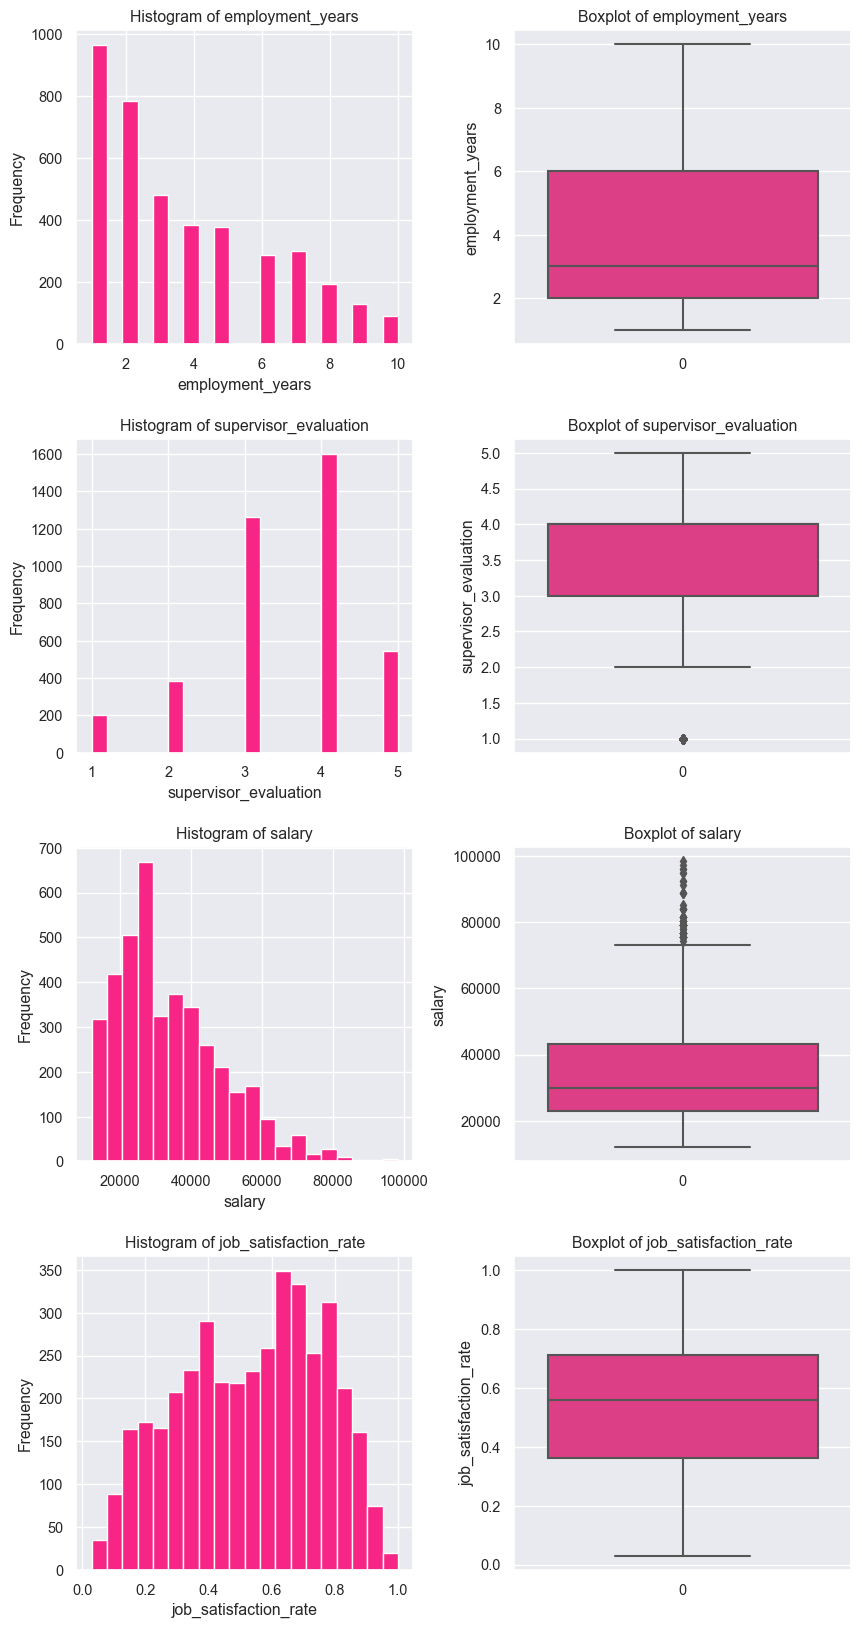

In [23]:
hist_box(train_rate)

In [24]:
train_rate.select_dtypes(include=['number']).describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


Оценка качества работы сотрудника, которую дал руководитель и ежемесячная зарплата сотрудника содержат выбросы, но удалять их не следует - такие значения имеют место быть.

Данные распределены не нормально. Средние и медианные значения близки друг к другу.

Среднестатистический сотрудник выглядит так:
- длительность работы в компании равна 3 года;
- оценка качества работы сотрудника, которую дал руководитель - 4;
- ежемесячная зарплата сотрудника - 30 000 рублей;
- уровень удовлетворённости сотрудника работой в компании (целевой признак) - 0.56.

Посмотрим на категориальные признаки.

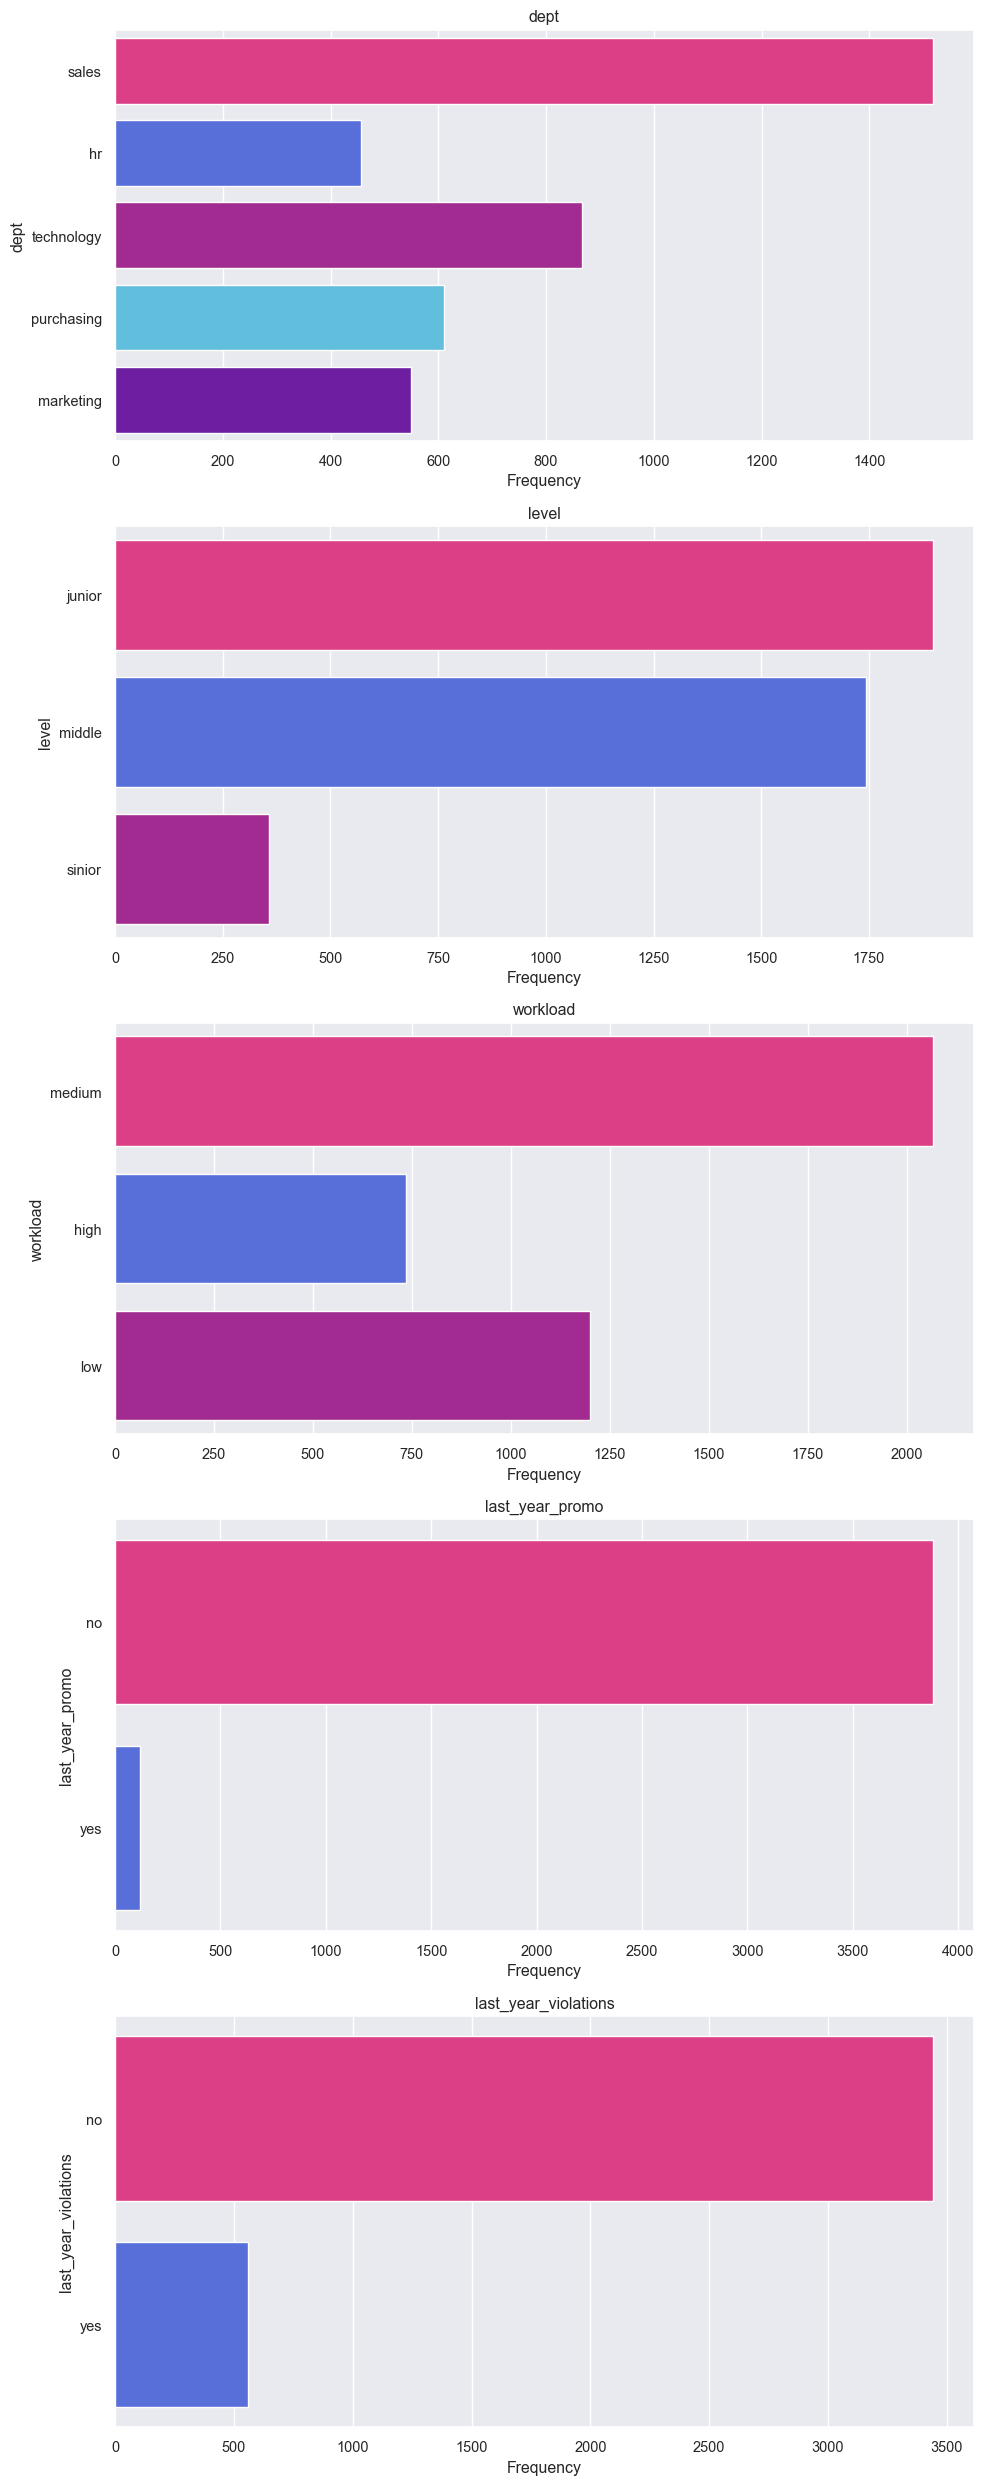

In [25]:
get_catplot(train_rate)

Большинство сотрудников в датасете работают в отделе продаж с уровнем должности джуниор или миддл, уровень загруженности сотрудника - средний, повышение за последний год получили менее 200 сотрудников, а трудовой договор за последний год нарушило чуть более 500 сотрудников.

Проверим тестовую выборку.

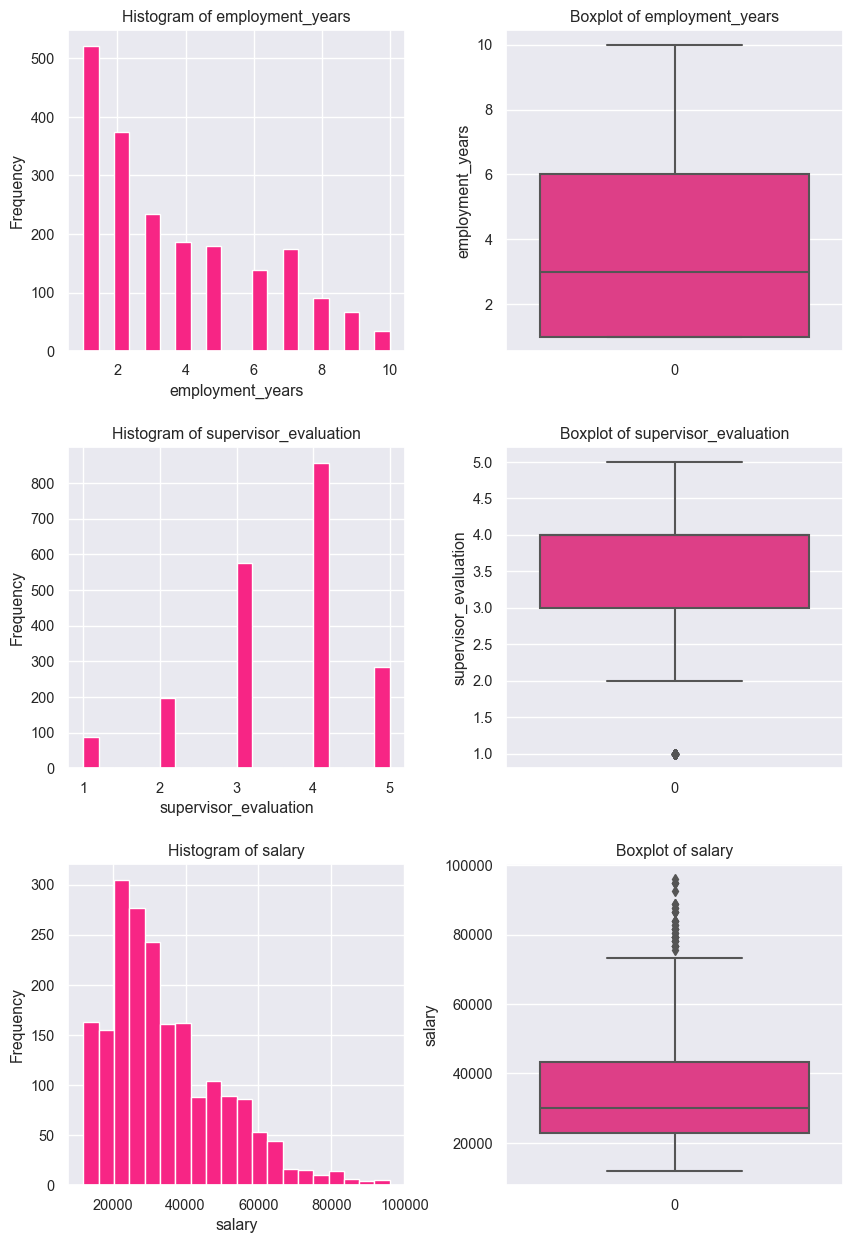

In [26]:
hist_box(test_features)

In [27]:
test_features.select_dtypes(include=['number']).describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Значения количественных признаков тестовой выборки практически индентичны значениям в тренировочной выборке.

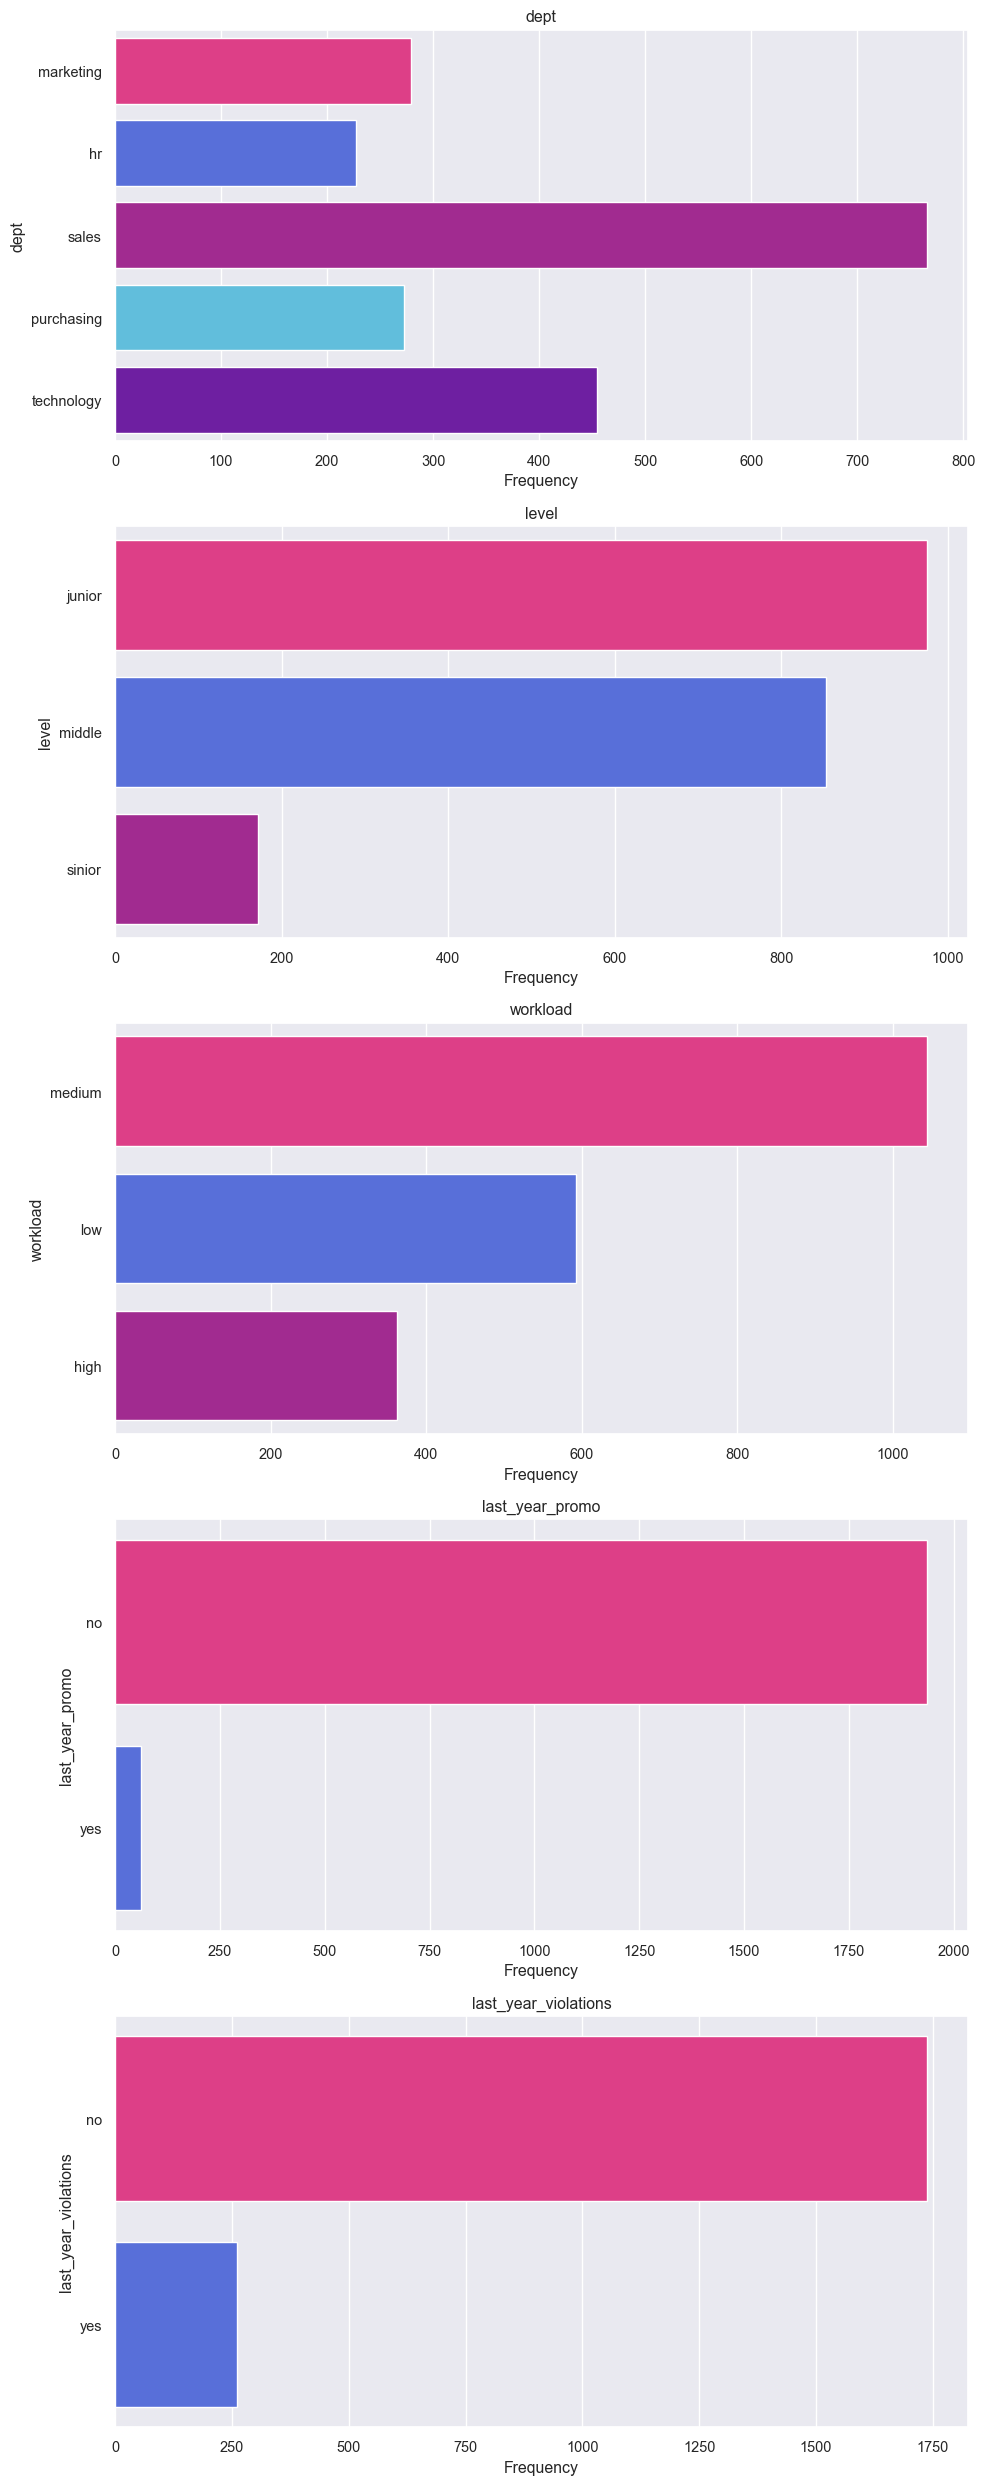

In [28]:
get_catplot(test_features)

Количественные значения также похожи на значения тренировочной выборки.

Проверим целевой признак тестовой выборки.

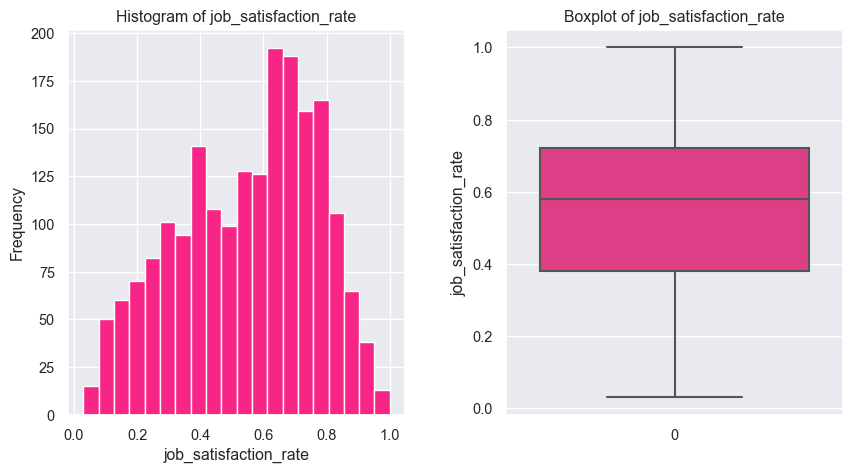

In [29]:
hist_box(test_rate)

Аномалий и выбросов нет.

Проверим наличие мультиколлинеарности.

In [30]:
phik_x = train_rate.drop('job_satisfaction_rate', axis=1)
phik_y = train_rate['job_satisfaction_rate']
interval_cols = train_rate.select_dtypes(include=['number'])\
.columns

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(phik_x.join(phik_y), interval_cols=interval_cols) 

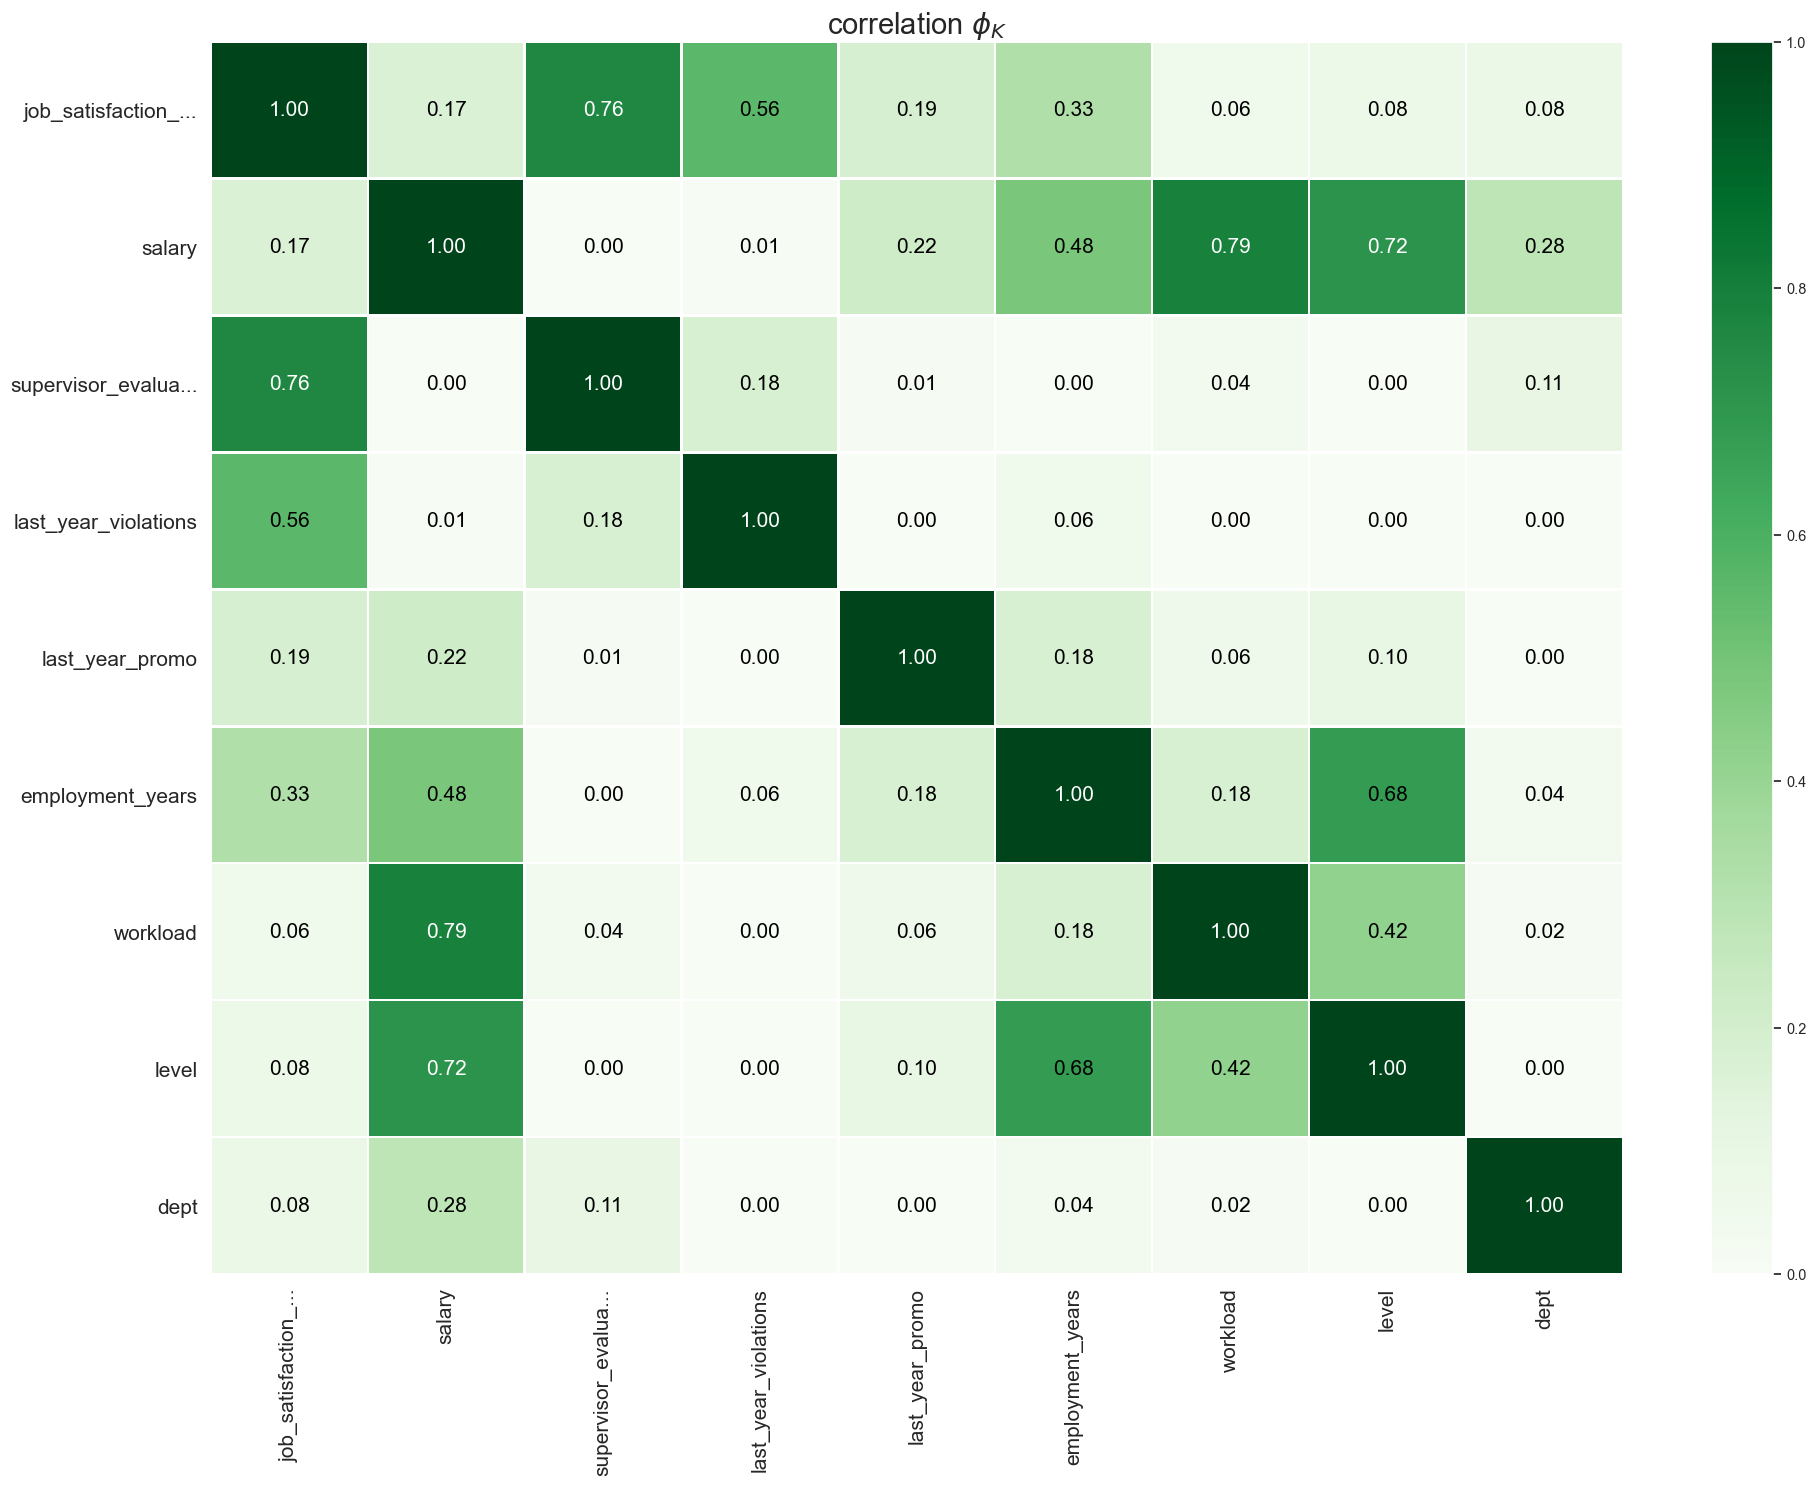

In [31]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Мультиколлинеарность - сильная линейная взаимосвязь между входными признаками. О ней говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. Таких коэффициентов в данной выборке нет, значит, **мультиколлинеарности нет.**

**Вывод:** в результате исследовательского анализа данных НЕ обнаружены аномальные значения. В данных присутствуют выбросы. Мультиколлинеарности нет.

При подготовке данных надо сделать следующее: 
- OneHotEncoder для `last_year_promo`, `last_year_violations`;
- OrdinalEncoder для `dept`, `level`, `workload`;
- MinMaxScaler или StandardScaler для количественных признаков.

<a id='pipe1'></a>
### Подготовка данных

Подкорректируем разделение на выбоки.

In [32]:
X_train = train_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_rate['job_satisfaction_rate']

X_test = test_features.merge(test_rate, how='left', on='id')
y_test = X_test['job_satisfaction_rate']
X_test = X_test.drop(['job_satisfaction_rate'], axis=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4000, 8), (4000,), (2000, 8), (2000,))

Создаем списки с названиями признаков для дальнейшей обработки.

In [33]:
# признаки для OneHotEncoder
ohe_columns = ['last_year_promo', 'last_year_violations']
# признаки для OrdinalEncoder
ord_columns = ['dept', 'level', 'workload']
# признаки для масштабирования
num_columns = ['employment_years', 
               'supervisor_evaluation', 
               'salary']

ohe_columns, ord_columns, num_columns

(['last_year_promo', 'last_year_violations'],
 ['dept', 'level', 'workload'],
 ['employment_years', 'supervisor_evaluation', 'salary'])

Создаём пайплайн для подготовки признаков из списка ohe_columns: OHE-кодирование, и пайплайн для подготовки признаков из списка ord_columns: Ordinal-кодирование.

In [34]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
   [('simpleImputer_ohe', 
     SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
   ]
   )

# SimpleImputer + ORD
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', 
     SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord',  OrdinalEncoder( 
        categories=[
            ['sales', 'hr', 'technology', 'purchasing', 'marketing'],
            ['junior', 'middle', 'sinior'],
            ['low', 'medium', 'high'],
        ], 
        handle_unknown='use_encoded_value', unknown_value=np.nan)
       ),
    ('simpleImputer_after_ord', 
     SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
   ]
)


TypeError: __init__() got an unexpected keyword argument 'sparse'

Создаём общий пайплайн для подготовки данных.

In [ ]:
preprocessor = ColumnTransformer(
   [('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
   ],
   remainder='passthrough'
)

Создаём итоговый пайплайн с подготовкой данных и моделью.

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

<a id='mod1'></a>
### Обучение моделей

При подборе гиперпараметров и оценки качества модели возьмем метрику SMAPE - симметричное среднее абсолютное процентное отклонение.

Напишем функцию, принимающую на вход массивы NumPy или объекты Series в pandas и возвращающую значение метрики SMAPE.

In [ ]:
def smape_func(true_y, pred_y):
    num = np.abs(true_y - pred_y)
    denom = (np.abs(true_y) + np.abs(pred_y)) / 2.0
    return np.mean(num / denom) * 100

In [ ]:
smape_score = make_scorer(smape_func, greater_is_better=False)

Обучим модели. 

Подберем гиперпараметры для дерева решений с помощью пайплайнов.

In [ ]:
param_grid = [
   # словарь для модели DecisionTreeRegressor()
   {
       'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
       'models__min_samples_split': range(2, 200),
       'models__min_samples_leaf': range(2, 10),
       #'models__max_leaf_nodes': range(1, 10),
       'models__max_depth': range(2, 150),
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
   },
]

In [ ]:
randomized_search = RandomizedSearchCV(
   pipe_final,
   param_grid,
   cv=5,
   scoring=smape_score,
   random_state=RANDOM_STATE,
   n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели:', round(randomized_search.best_score_, 2))

y_pred = randomized_search.predict(X_test)
print('Метрика SMAPE на тестовой выборке:',  round(smape_func(y_test, y_pred), 2))

Обучим модель линейной регрессии.

In [ ]:
X_train_lr = preprocessor.fit_transform(X_train)
X_test_lr = preprocessor.transform(X_test)

model_lr  = LinearRegression()
model_lr.fit(X_train_lr, y_train)

# предсказанные значения для X_test
y_pred_lr = model_lr.predict(X_test_lr)
print('Метрика SMAP на тестовой выборке:', 
      round(smape_func(y_test, y_pred_lr), 2))

**Вывод:** лучшая модель - дерево решений `DecisionTreeRegressor` со следующими параметрами: 
- `max_depth=113`, 
- `min_samples_leaf=6`,
- `min_samples_split=18`.

Модель дерева справляется с предсказаниями лучше модели линейной регрессии (значение метрики SMAPE 13.89 против 24.38).

<a id='conc1'></a>
### Промежуточные выводы

Дерево решений справилось лучше, потому что в данных присутствуют выбросы, к которым модель линейной регрессии чувствительна.

<a id='task2'></a>
## Задача 2: предсказание увольнения сотрудника из компании

<a id='gen2'></a>
### Загрузка данных

Считываем датафреймы.

In [ ]:
# считываем датафреймы
# записываем возможные пути
paths = ['/datasets/', 
         'C:\\Users\\Admin\\YandexDisk\\']
# разделение данных
sep=[',', '.']

df_name = 'train_quit.csv'
train_quit = read_dfs(paths, df_name, sep)

df_name = 'test_target_quit.csv'
test_quit = read_dfs(paths, df_name, sep)

In [ ]:
print(train_quit.info())
train_quit.head()

**Вывод:** пропусков нет, типы данных правильные.

In [ ]:
print(test_quit.info())
test_quit.head()

**Вывод:** пропусков нет, типы данных правильные.

<a id='prep2'></a>
### Предобработка данных

Проверим данные на наличие явных дубликатов.

In [ ]:
print('Кол-во дубликатов в train_quit:', 
      train_quit.duplicated().sum())
print('Кол-во дубликатов в test_quit:', 
      test_quit.duplicated().sum())

Явных дубликатов нет.

Проверим данные на наличие неявных дубликатов.

In [ ]:
# выбираем только категориальные признаки
cat_col = train_quit\
.select_dtypes(exclude=['number']).columns

for col in cat_col:
    print('Столбец', col, train_quit[col].unique())
    
test_quit['quit'].unique()

**Вывод:** в датафреймах нет дубликатов и пропусков.

<a id='res2'></a>
### Исследовательский анализ данных

In [ ]:
# устанавливаем вместо индекса id
train_quit = train_quit.set_index('id')
test_quit = test_quit.set_index('id')

In [ ]:
# функция гистограммы для сравнения по целевому признаку
def hist_comparsion(df_yes, df_no, feature, binss):
    ax = df_no.plot(
        kind='hist',
        y=feature,
        bins=binss,
        alpha=1,
        label='not quit'
    )
    df_yes.plot(
        kind='hist',
        y=feature,
        bins=binss,
        alpha=.6,
        label='quit',
        ax=ax,
        grid=True
    )
    plt.title(feature)
    plt.ylabel('Frequency')
    plt.xlabel(feature)
    plt.show()
    
    
# функция построения двух боксплотов для сравнения
# по целевому признаку
def box_comparsion(df_yes, df_no, feature):
    plt.figure(figsize=(6, 5))

    # 1 строка, 2 столбца. Текущая ячейка 1
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_yes[feature].values)
    plt.title('quit')
    plt.xlabel(feature)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_no[feature].values)
    plt.title('not quit')
    plt.xlabel(feature)
    
    # расстояние между графиками
    plt.subplots_adjust(wspace=1)
    plt.show()

In [ ]:
# функция сравнения графиков ДОЛЕЙ для категориальных признаков
def catplot_cmprsn(df):
    colmns = df.drop('quit', axis=1)
    colmns = colmns.select_dtypes(exclude=['number']).columns
    # размер графика
    num_plots = len(colmns)
    plt.figure(figsize=(10, 6 * num_plots))

    for i, col in enumerate(colmns):
        plt.subplot(num_plots, 2, 2*i + 1)
        sns.histplot(
            df, 
            x=col, 
            hue='quit', 
            stat='probability',
            multiple='dodge')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('Probability')
        plt.xticks(rotation=90)
          
    plt.subplots_adjust(hspace=0.4)
    plt.show()

Разделяем данные по целевому признаку `quit`.

In [ ]:
did_quit = train_quit[train_quit['quit'] == 'yes']
not_quit = train_quit[train_quit['quit'] == 'no']

Длительность работы в компании (в годах).

In [ ]:
hist_comparsion(did_quit, not_quit, 'employment_years', 20)
box_comparsion(did_quit, not_quit, 'employment_years')
print('Статистика уволившихся сотрудников:')
did_quit['employment_years'].describe()

In [ ]:
print('Статистика не уволившихся сотрудников:')
not_quit['employment_years'].describe()

**Вывод:** длительность работы в компании большей части уволившихся сотрудников составляет год-два, когда средняя длительность не уволившегося сотрудника - 4 года.

In [ ]:
hist_comparsion(did_quit, not_quit, 'supervisor_evaluation', 5)
box_comparsion(did_quit, not_quit, 'supervisor_evaluation')
print('Статистика уволившихся сотрудников:')
did_quit['supervisor_evaluation'].describe()

In [ ]:
print('Статистика не уволившихся сотрудников:')
not_quit['supervisor_evaluation'].describe()

**Вывод:** средняя оценка качества работы уволившегося сотрудника, данная руководителем, равна 3, у не уволившегося она выше - 4.

In [ ]:
hist_comparsion(did_quit, not_quit, 'salary', 50)
box_comparsion(did_quit, not_quit, 'salary')
print('Статистика уволившихся сотрудников:')
did_quit['salary'].describe()

In [ ]:
print('Статистика не уволившихся сотрудников:')
not_quit['salary'].describe()

**Вывод:** средняя зарплата уволившихся сотрудников значительно меньше, чем у оставшихся - 22 800 руб. против 34 800 руб. Также ЗП среди уволившихся редко достигала значения больше 27 600 рублей.

In [ ]:
catplot_cmprsn(train_quit)

**Распределение по департаментам:**
- Продажи
    - доля уволившихся: 0.1
    - доля оставшихся:  0.26
- Закупки:
    - доля уволившихся: 0.04
    - доля оставшихся:  0.1
- Маркетинг:
    - доля уволившихся: 0.04
    - доля оставшихся:  0.1
- Технический:
    - доля уволившихся: 0.07
    - доля оставшихся:  0.16
- HR: 
    - доля уволившихся: 0.09
    - доля оставшихся:  0.04

**Распределение по должностям:**
- Джуниор
    - доля уволившихся: 0.25
    - доля оставшихся:  0.24
- Миддл
    - доля уволившихся: 0.03
    - доля оставшихся:  0.39
- Сеньор
    - доля уволившихся: 0.08
    - доля оставшихся:  0.01
    
**Распределение по уровню загруженности:**
- Низкий
    - доля уволившихся: 0.13
    - доля оставшихся:  0.17
- Средний
    - доля уволившихся: 0.12
    - доля оставшихся:  0.41
- Высокий
    - доля уволившихся: 0.03
    - доля оставшихся:  0.14

**Распределение по наличию повышения за последний год:**
- Повышение было
    - доля уволившихся: 0
    - доля оставшихся:  0.02
- Повышения не было
    - доля уволившихся: 0.29
    - доля оставшихся:  0.69
    
**Распределение по наличию нарушений трудового договора за последний год:**
- Нарушение было
    - доля уволившихся: 0.06
    - доля оставшихся:  0.08
- Нарушения не было
    - доля уволившихся: 0.22
    - доля оставшихся:  0.64

**Вывод:** 
Чаще всего увольняются сотрудники отдела продаж на должности джуниора и с низким или среднем уровнем загруженности. Уволившиеся сотрудники также не получали повышения за год, но и не нарушали трудовой договор (хотя доля нарушавших среди уволившихся больше чем среди оставшихся).

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

In [ ]:
full_df = test_features.merge(test_rate, how='left', on='id')
full_df = full_df.merge(test_quit, how='left', on='id')

full_df.info()

In [ ]:
did_quit = full_df[full_df['quit'] == 'yes']
not_quit = full_df[full_df['quit'] == 'no']

hist_comparsion(did_quit, not_quit, 'job_satisfaction_rate', 20)
box_comparsion(did_quit, not_quit, 'job_satisfaction_rate')

Проверим гипотезы:
- **Нулевая гипотеза:** уровень удовлетворённости работой в компании **одинаковый** у уволившихся и оставшихся сотрудников;
- **Альтернативная гипотеза:** уровень удовлетворённости работой в компании у уволившихся сотрудников **меньше**, чем у оставшихся.

In [ ]:
from scipy import stats as st

In [ ]:
print('Средний уровень удовлетворенности работой у УВОЛИВШИХСЯ:',\
      round(did_quit['job_satisfaction_rate'].mean(), 2))
print('Средний уровень удовлетворенности работой у ОСТАВШИХСЯ',\
      round(not_quit['job_satisfaction_rate'].mean(), 2))

# выбранный уроваень статистической значимости
alpha = .05

results = st.ttest_ind(
    did_quit['job_satisfaction_rate'],
    not_quit['job_satisfaction_rate'],
    alternative='less',
    equal_var=False
)

print('p-значение:', results.pvalue)

# вывод о нулевой гипотезе
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

**Вывод:** нулевая гипотеза о том, что уровень удовлетворённости работой в компании одинаков у уволившихся и оставшихся сотрудников, - отвергнута. Есть основания утверждать, что верна альтернативная гипотеза -  уровень удовлетворённости работой в компании у уволившихся сотрудников меньше, чем у оставшихся.

<a id='add'></a>
### Добавление нового входного признака

Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [ ]:
test_features.shape, test_quit.shape

In [ ]:
# добвление признака в тренировочную выборку
train_quit['job_satisfaction_rate'] = randomized_search.predict(X_train)

# добавление признаков в тестовую выборку
test_features = test_features.merge(test_quit, how='left', on='id')
test_features['job_satisfaction_rate'] = randomized_search.predict(X_test)
test_features.info()

Проверим наличие мультиколлинеарности.

In [ ]:
phik_x = train_quit.drop('quit', axis=1)
phik_y = train_quit['quit']
interval_cols = train_quit.select_dtypes(include=['number'])\
.columns

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(phik_x.join(phik_y), interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Мультиколлинеарности нет.

<a id='pipe2'></a>
### Подготовка данных

Разбиваем данные на выборки.

In [ ]:
X_train_quite = train_quit.drop(['quit'], axis=1)
y_train_quite = train_quit['quit']

X_test_quite = test_features.drop(['quit'], axis=1)
y_test_quite = test_features['quit']

X_train_quite.shape, y_train_quite.shape, X_test_quite.shape, y_test_quite.shape

Кодируем целевой признак - `quit`.

In [ ]:
label_encoder = LabelEncoder()
y_train_quite = label_encoder.fit_transform(y_train_quite)
y_test_quite = label_encoder.transform(y_test_quite)

label_encoder.classes_

Создаем списки с названиями признаков для дальнейшей обработки.

In [ ]:
# признаки для OneHotEncoder
ohe_columns = ['last_year_promo', 'last_year_violations']
# признаки для OrdinalEncoder
ord_columns = ['dept', 'level', 'workload']
# признаки для масштабирования
num_columns = ['employment_years', 
               'supervisor_evaluation', 
               'salary',
               'job_satisfaction_rate']

ohe_columns, ord_columns, num_columns

In [ ]:
pipe_final_m2 = Pipeline([
    ('preprocessor', preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Дальнейшую обработку проведем с помощью уже написанного пайплайна во время перебора гиперпараметров.

<a id='mod2'></a>
### Обучение моделей

Обучим три модели. Для двух из них подберем гиперпараметры. Качество лучшей модели проверим с помощью метрики ROC-AUC.

Подготавливаем словари с гиперпараметрами для моделей.

In [ ]:
param_grid_m2 = [
   # словарь для модели DecisionTreeClassifier()
   {
       'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
       'models__max_depth': range(2, 31),
       'models__max_features': range(2, 11),
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
   },

   # словарь для модели KNeighborsClassifier()
   {
       'models': [KNeighborsClassifier()],
       'models__n_neighbors': range(2, 21),
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
   },
    
   # словарь для модели LogisticRegression()
   {
       'models': [LogisticRegression(
           random_state=RANDOM_STATE,
           solver='liblinear',
           penalty='l1'
       )],
       'models__C': [0.1, 1.0, 5.0, 10.0, 50.0],
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
   }
]

In [ ]:
randomized_search_m2 = RandomizedSearchCV(
   pipe_final_m2,
   param_grid_m2,
   cv=5,
   scoring='roc_auc',
   random_state=RANDOM_STATE,
   n_jobs=-1
)
randomized_search_m2.fit(X_train_quite, y_train_quite)

print('Лучшая модель и её параметры:\n\n', randomized_search_m2.best_estimator_)
print ('Метрика лучшей модели:', round(randomized_search_m2.best_score_, 2))

# проверяем работу модели на тестовой выборке
# рассчитываем прогноз на тестовых данных
quite_pred = randomized_search_m2.predict_proba(X_test_quite)
print('Метрика ROC-AUC на тестовой выборке:',
      round(roc_auc_score(y_test_quite, quite_pred[:,1]), 2))

**Вывод:** лучшая модель - дерево решений `KNeighborsClassifier` со следующими параметрами: 
- `n_neighbors=10`.

<a id='conc2'></a>
### Промежуточные выводы

В данной задаче (предсказание увольнения сотрудника) лучше справилась модель K-Ближайших соседей. Этот метод хорошо работает на выборках с небольшим количеством признаков, так как запоминает данные и дальше просто подбирает наиболее похожее значение.

<a id='conc'></a>
## Общий вывод

**Целью проекта определено следующее:**
- Построить модель, предсказывающую уровень удовлетворённости сотрудника на основе данных заказчика.
- Построить модель, предсказывающую увольнение сотрудника из компании на основе данных заказчика.

**Исходные данные:**
- **Таблицы задачи 1: предсказание уровня удовлетворённости сотрудника.**
    - Тренировочная выборка: `train_job_satisfaction_rate.csv`
    - Входные признаки тестовой выборки: `test_features.csv`
    - Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`
    
- **Таблицы задачи 2: предсказание увольнения сотрудника из компании.**
    - Тренировочная выборка: `train_quit.csv`
    - Входные признаки тестовой выборки те же, что и в 1 задаче: `test_features.csv`
    - Целевой признак тестовой выборки: `test_target_quit.csv`

**В ходе выполнения работы проделаны следующие шаги:**
- Загружены и проверены соответствия данных в датафреймах;
- В результате **предобработки данных** удалены дубликаты, обработаны пропуски с помощью пайплайна;
- В ходе **исследовательского анализа данных** проведен корреляционный анализ признаков для проверки наличия мультиколлинеарности, которая мешает моделированию;
- Для автоматизации **подготовки данных** использованы пайплайны для масштабирования, кодирования признаков и заполнения пропусков;
- С помощью пайплайнов и автоматизированного поиска гипермараметров подобраны лучшие способы обработки,  гиперпараметры и лучшие модели. Оценка производилась по метрике SMAPE для задачи регрессии (задача 1) и ROC-AUC для задачи классификации (задача 2).

**Выводы и предложения для бизнеса:**

Портрет уволившегося сотрудника: 
- **Длительность работы в компании** 1-2 года;
- **Оценка качества работы сотрудника**, данная руководитель, равна 3 из 5;
- **Зарплата** - 22 800 руб.;
- **Отдел**, в котором работает сотрудник - продажи;
- **Должность** - джуниор;
- **Уровень загруженности** - низкий или средний;
- **Повышения** за последний год не было;
- **Нарушений трудового договора** сотрудником за последний год не было;
    - Следует учитывать, что нарушение договора повышает шанс увольнения.
-  **Уровень удовлетворённости сотрудника работой в компании** 0.33 (по кале от 0 до 1).
    
**Рекомендации:**
- Большинство увольняющихся сотрудников работают в компании не больше двух лет, занимают позицию джуниора и их работа оценивается на 3 из 5, значит, данные сотрудники плохо освоились на рабочем месте, возможно, что-то не понимают. Может помочь наставничество или обучение новых сотрудников, если оно уже сущетсвует, то следует пересмотреть методы.
- Увольняющиеся сотрудники получают довольно маленькую зарплату при низком-среднем уровне загруженности, и при длительности работы в компании 1-2 года за последний год у них не было повышений. Если сотрудник хорошо выполняет свою работу, то премии, поднятие зарплаты или повышение могут мотивировать его не уходить из комании. 
- Следует обратить внимание на другие факторы, связанные с компанией и влияющие на уровень удовлетворённости сотрудника работой, которые не были учтены в данном проекте: коллектив, место работы и отдыха, отношение руководителя и другие.

[Наверх][1]

[1]:#task